#I. Import Necessary Libraries

In [53]:
#import necessary libraries
import os
import torch
import numpy as np
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#retrieve the data
#train and test data directory
train_dir = "./drive/MyDrive/SkinDisease/train"
test_dir = "./drive/MyDrive/SkinDisease/train"

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

#II. Examine Data Set

In [45]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(f"✅ Loaded {len(train_dataset)} training and {len(test_dataset)} test images")
print(f"📚 Number of classes: {len(class_names)} → {class_names}")

✅ Loaded 13898 training and 13898 test images
📚 Number of classes: 22 → ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


1. Check images

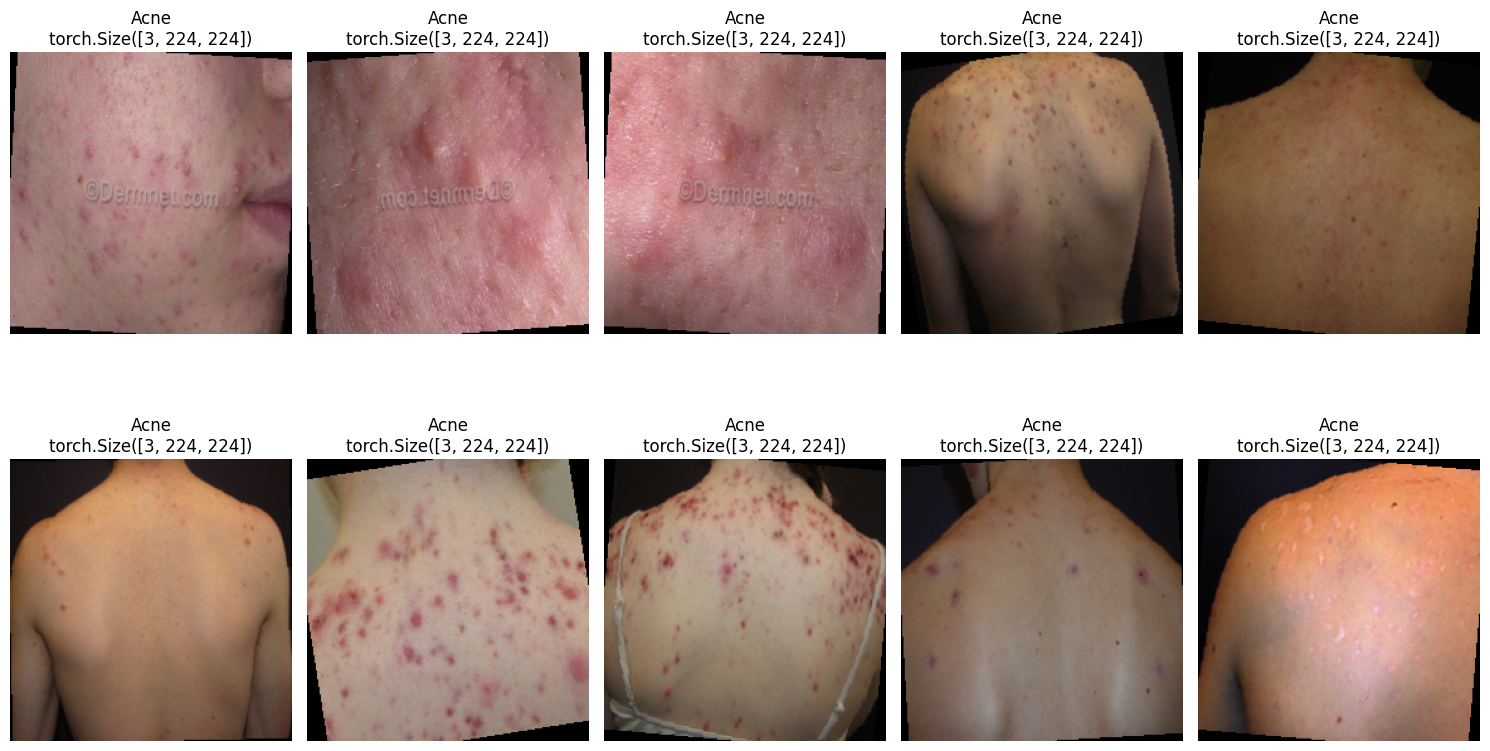

In [37]:
#view some example images
n = 5

fig, axes = plt.subplots(2, n, figsize=(15, 9))
for j in range(2):
  for i in range(n):
      image, label = train_dataset[i + (j*n)]
      img_display = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
      axes[j][i].imshow(img_display)
      axes[j][i].set_title(f"{class_names[label]}\n{image.shape}")
      axes[j][i].axis("off")
plt.tight_layout()
plt.show()

In [38]:
# we see images in the same category can vay by severity and location

2. Check image sizes

In [ ]:
shapes = (img[0].shape for img in train_dataset)
shape_counts = Counter(shapes)
print("Image shapes in dataset:", shape_counts)

#III. Exploritory Data Analysis

1. Class distributions

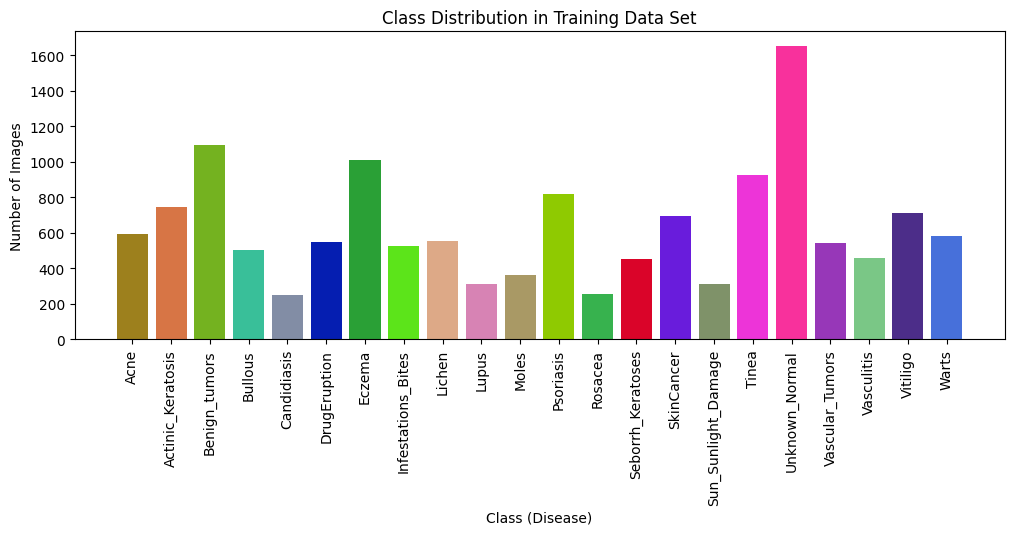

In [28]:
label_counts = Counter(train_dataset.targets)
plt.figure(figsize=(12, 4))

colors = [(random.random(), random.random(), random.random()) for _ in range(len(label_counts))]

plt.bar(class_names, label_counts.values(), color=colors)
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Data Set")
plt.ylabel("Number of Images")
plt.xlabel("Class (Disease)")

plt.show()

In [29]:
# we see a high amount of unkown_normal, benign_tumors, and Eczema,
# while there is a lot less Candidiasis and rosacea

2. Examine Weighted Loss

In [43]:
labels = train_dataset.targets
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=np.array(labels))
class_weights = torch.tensor(class_weights, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"Class weights tensor: {class_weights}")

Class weights tensor: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892])


#IV. Train Models

In [48]:
num_classes = 22

## 1. EfficientNetV2

1. Load Model

In [47]:
effNet_Model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 177MB/s]


2. Set loss and Optimizer

In [57]:
effNet_Model.classifier[1] = nn.Linear(effNet_Model.classifier[1].in_features, num_classes)
effNet_Model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(effNet_Model.parameters(), lr=1e-4)



3. Train

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    effNet_Model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = effNet_Model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

## 2. ResNet18

## 3. MobileNet V3

# V. Compare Results

# Save Model for external use